Ćwiczenie polega na zbudowaniu modelu klasyfikacji (wieloklasowej) gdzie zbiorem wejściowym będzie przestrzeń ukryta autoenkodera. 
Na początku zbuduję autoenkoder (definicja w pliku AE.py) i skorzystam z jego warstwy ukrytej jako zbioru treningowego. 
Skorzystam z danych mnist https://keras.io/api/datasets/mnist/  

In [1]:
# importuuję potrzebne biblioteki
import os
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt


from utils.loaders import load_mnist, load_model
from models.AE import Autoencoder

Using TensorFlow backend.


In [2]:
# ustalam parametry oraz tworzę strukturę katalogów do zapisania modeli
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [3]:
# pobieramy dane oraz tworzę zbiory treningowe oraz testowe
(x_train, y_train), (x_test, y_test) = load_mnist()

([<matplotlib.axis.XTick at 0x24db6bf4748>,
 <a list of 10 Text xticklabel objects>)

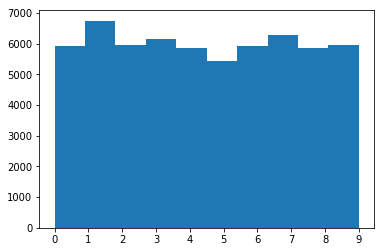

In [8]:
# sprawdzenie rozkładu 
from collections import Counter 
import matplotlib.pyplot as plt
#c = Counter(y_train)



plt.hist(list(y_train)) 
plt.xticks(list(np.arange(0,10)))

In [21]:
# definicja struktury autoenkodera. Definiujemy poniżej parametry poszczególnych warstw
AE = Autoencoder(
    input_dim = (28,28,1)  #wymiar wejścia
    # definicja sekwencyjnego stosu warstw konwolucyjnych 
    , encoder_conv_filters = [32,64,64, 64]  # wymiar filtrów
    , encoder_conv_kernel_size = [3,3,3,3]  # wymiar jądra warstwy splotowej
    , encoder_conv_strides = [1,2,2,1]   # krok przemieszczenia jądra
    , decoder_conv_t_filters = [64,64,32,1]  # wymiar filtrów transponowanych 
    , decoder_conv_t_kernel_size = [3,3,3,3] # wymiar jądra transponowanego 
    , decoder_conv_t_strides = [1,2,2,1] # liczba kroków transponowanych 
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

W0127 00:09:47.068427 39824 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0127 00:09:47.071424 39824 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [6]:
# przyglądam się strukturze naszego modelu
AE.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
__________

In [22]:
# definiuję hiperparametry, stosuję typowe dla tego typu problemu
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

In [23]:
# należy pamiętać o skompilowaniu modelu po dowolnej modyfikacji parametrów np. po rozmrożeniu warstw, inicjacji parametrów
AE.compile(LEARNING_RATE)

W0127 00:09:55.807587 39824 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [ ]:
# Trenuję model
AE.train(     
    x_train[:1000]
    , batch_size = BATCH_SIZE
    , epochs = 200
    , run_folder = RUN_FOLDER
    , initial_epoch = INITIAL_EPOCH
)

In [4]:
# ładujemy model jeżeli wystartujemy kolejny raz żeby nie trzeba było go trenować za każdym razem
AE = load_model(Autoencoder, RUN_FOLDER)

W0127 22:49:44.211154 36996 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0127 22:49:44.233830 36996 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0127 22:49:44.435709 36996 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0127 22:49:44.436709 36996 module_wrapper.py:139] From E:\Python\Anaconda\envs\generative\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0127 22:49:44.436709 36996 module_wrapper.py:1

In [ ]:
# możliwe wartości parametru cmap
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 
'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 
'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 
'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 
'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 
'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 
'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 
'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 
'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 
'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 
'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 
'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 
'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 
'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 
'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 
'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 
'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 
'viridis', 'viridis_r', 'winter', 'winter_r'

W tym miejscu mamy już wytrenowany model, możemy przyglądnąć się jak wygląda graficznie przestrzeń ukryta. 
Dodatkowo wrzucam na wykresie równorozłożoną siatkę punktów i dla nich wyświetlam wynik działania naszego autoencodera jako generatora obrazów cyfr odpowiadającym poszczególnym punktom.   

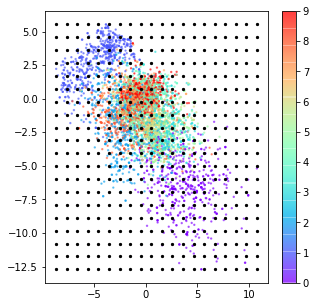

In [25]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)
#plt.savefig("latent_space.png", format='png', dpi=300, facecolor="White")
plt.show()




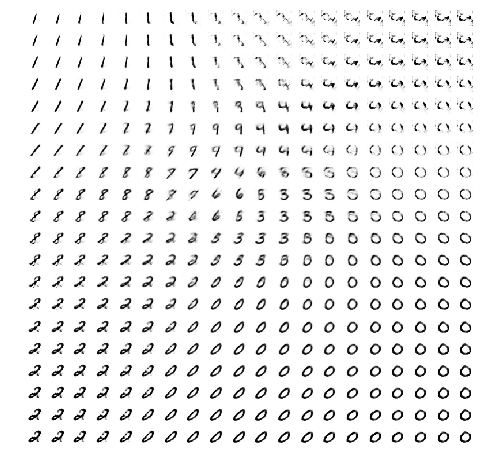

In [14]:
# wygenerowane obrazy cyfr przez nasz model
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
#plt.savefig("grid_reconstruction.png", format='png', dpi=300, facecolor="White")

Poprzedni wykres stanowi świetną wizualizację jak powinien wyglądać przestrzeń klasyfikacji dobrego modelu. 
Ponieważ model SVM jest bardzo czuły na dobór hiperparametrów, spakuję go do funkcji. 
Jednocześnie pomijam krok normalizacji i standaryzacji, zaburzy nam to porównanie wyników a przy tak małym zakresie nie będzie to miało większego wpływu na model

In [16]:
# budowa modelu SVM. Zbiorem treningowym będzie przestrzeń ukryta, zmienną celu natomiast nasza narysowana liczba
#from sklearn.multiclass import OneVsOneClassifier # możemy pominąć, model sam się skapnie że zmienna celu nie jest binarna
from sklearn.svm import SVC

# tworzę wartswę ukrytą i na niej buduję multiklasowy model SVM 
X_svm = AE.encoder.predict(x_test)
y_svm = y_test

# wartości brzegowe przestrzeni ukrytej, zaookrąglę i skorzystam do tworzenia wykresów
print(np.min(X_svm[:,0]), np.max(X_svm[:,0]))
print(np.min(X_svm[:,1]), np.max(X_svm[:,1]))


-9.40345 11.00873
-12.710449 5.8599863


Natępny urywek kodu definiuje funkcję do generowania wykresów przy zadanych parametrach wejścowych

In [18]:
def plot_comparitions(clf, axis, clf_par, z_points, example_labels):
    x0s = np.linspace(axis[0], axis[1], 100)
    x1s = np.linspace(axis[2], axis[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xn = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(Xn).reshape(x0.shape)
    #wykresy
    fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
    plt.sca(axes[0])
    plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[0,1,2,3,4,5,6,7,8,9],  alpha=0.5)
    plt.colorbar()
    plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(clf_par[0],clf_par[1]), fontsize=14)
    plt.sca(axes[1])
    plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
                , alpha=0.5, s=2)
    plt.colorbar()
    plt.title(r"Przestrzeń ukryta autoenkodera", fontsize=14)
    plt.ylabel("")
    plt.savefig("compare_for_C{0}_gamma{1}.png".format(clf_par[0],clf_par[1]), format='png', dpi=300, facecolor="White")
    plt.show()

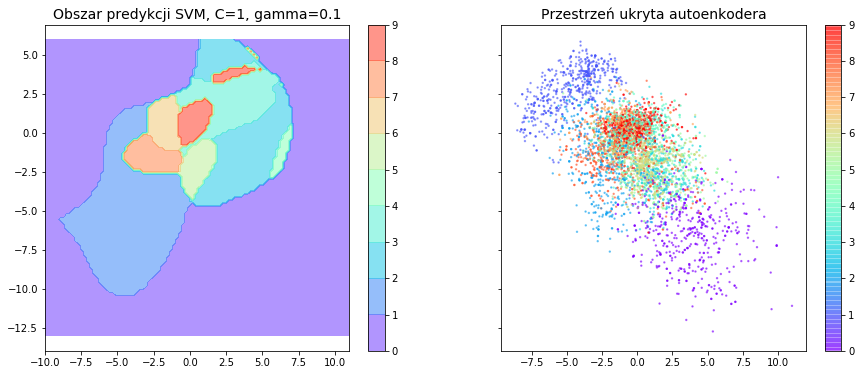

In [27]:
# należy podmienic ovr na ovo bo to zmieniło się w ostatniej wersji na domyślna
Cp = 1  #  0.001, 1000
gammap=0.1 # 0.1, 1, 5
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')
svm_model.fit(X_svm, y_svm)

plot_comparitions(svm_model, [-10.0, 11.0, -13.0, 6.0], [Cp,gammap], z_points, example_labels)

Jak widać dopasowałem model. W całym tym ćwiczeniu a konkretnie w finałowym celu tj. wykrywaniu anomalii brakuje nam jednego klocka. Mianowice "pusta przestrzeń" tj miejsca gdzie nie lądują żadne wyniki nie jest w żaden sposób modelowana, staje się ona finałowo częścią przypisaną do istniejących obiektów. Dlatego pomyślałem, żeby wypełnić tą przestrzeń wartościami odpowiedzialnymi za predykcję nieistniejącej liczby np. -1 i na tym zbiorze wybudować model SVM. 
Wypełnienie wykonam w ten sposób, aby wygenerować pary liczb z przedziału przestrzeni ukrytej i pozostawić jedynie te, które są oddalone od rzeczywistych danych nie więcej niż o _epsilon_

In [5]:
import numpy as np
from scipy.spatial import distance

# granica przestrzeni ukrytej [-10.0, 11.0, -13.0, 6.0]
x = np.linspace(-10.0, 11.0, 100)
y = np.linspace(-13.0, 6.0, 100)
xv, yv = np.meshgrid(x,y) 
xv = xv.flatten()
yv = yv.flatten()

# wyjściowa macież 
fill_grid = np.array(list(zip(xv, yv)))

#matryca z danymi z przestrzeni ukrytej 
X_svm = AE.encoder.predict(x_test)

# macierz odległości 
dist_matrix = distance.cdist(fill_grid,X_svm).min(axis=1)

E:\Python\Anaconda\envs\generative\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


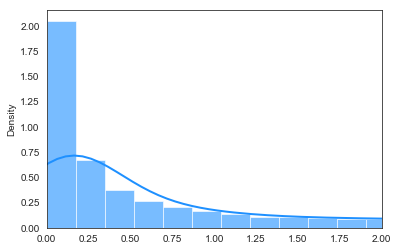

In [6]:
# sprawdzam na jakiej odległości postawić punkt odcięcia
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
#plt.style.use('ggplot')

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
sns.distplot(dist_matrix, color="dodgerblue", **kwargs)
plt.xlim(0,2)

plt.savefig("distance_distribution.png", format='png', dpi=200, facecolor="White")

#plt.hist(dist_matrix, bins=1000)
#plt.show()

Na podstawie tego wykresu wybieram _epsilon_=0.3

In [11]:
fill_grid_final = fill_grid[dist_matrix>0.5]

In [12]:
fill_grid_final.shape

(4702, 2)

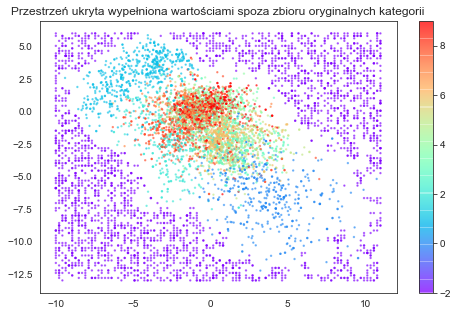

In [13]:
n_to_show = 5000
extra_n_to_show = 3000
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_idx_fill = np.random.choice(range(len(fill_grid_final)), extra_n_to_show)

example_images = x_test[example_idx]
example_labels = y_test[example_idx]
fill_set = fill_grid_final[example_idx_fill]
fill_labels = np.array( np.ones_like(range(extra_n_to_show))*-2)


z_points = AE.encoder.predict(example_images)
plot_set = np.concatenate((z_points, fill_set), axis=0)
cat_labels = np.concatenate((example_labels, fill_labels), axis = 0)


plt.figure(figsize=(8, 5))
plt.scatter(plot_set[:, 0] , plot_set[:, 1] , cmap='rainbow' , c= cat_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.title("Przestrzeń ukryta wypełniona wartościami spoza zbioru oryginalnych kategorii")

plt.savefig("synthetic_points05.png", format='png', dpi=300, facecolor="White")

Sprawdźmy jak się będzie teraz miał nasz nowy model SVM z dodatkową kategorią

In [17]:
def plot_comparitions_fill(clf, axis, clf_par, z_points, example_labels):
    x0s = np.linspace(axis[0], axis[1], 100)
    x1s = np.linspace(axis[2], axis[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xn = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(Xn).reshape(x0.shape)
    #wykresy
    fig, axes = plt.subplots(ncols=2, figsize=(15, 6), sharey=True)
    plt.sca(axes[0])
    plt.contourf(x0, x1, y_pred, cmap='rainbow', levels=[-2,0,1,2,3,4,5,6,7,8,9],  alpha=0.5)
    plt.colorbar()
    plt.title("Obszar predykcji SVM, C={0}, gamma={1}".format(clf_par[0],clf_par[1]), fontsize=14)
    plt.sca(axes[1])
    plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
                , alpha=0.5, s=2)
    plt.colorbar()
    plt.title(r"Wypełniona przestrzeń ukryta autoenkodera", fontsize=14)
    plt.ylabel("")
    plt.savefig("Fill_compare_for_C{0}_gamma{1}.png".format(clf_par[0],clf_par[1]), format='png', dpi=300, facecolor="White")
    plt.show()

In [18]:
#Stawiam na nowo zbiór uczący dla modelu SVM
X_svm_bis = np.concatenate((X_svm, fill_grid_final), axis = 0)
y_svm_bis = np.concatenate((y_svm, np.array( np.ones_like(range(len(fill_grid_final)))*-2)), axis=0)


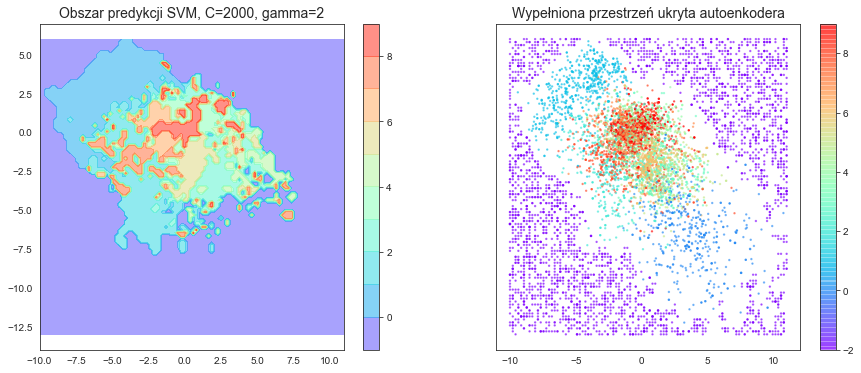

In [19]:
# należy podmienic ovr na ovo bo to zmieniło się w ostatniej wersji na domyślna
Cp = 2000  #  0.01, 1000
gammap=2 # 0.1, 1
svm_model  = SVC(kernel='rbf', gamma = gammap, C=Cp, decision_function_shape='ovo')
svm_model.fit(X_svm_bis, y_svm_bis)

plot_comparitions_fill(svm_model, [-10.0, 11.0, -13.0, 6.0], [Cp,gammap], plot_set, cat_labels)